# Simple gender analysis

- ## Imports

In [285]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import os, sys, json, re, argparse, urllib2, html5lib
from bs4 import BeautifulSoup, Tag, UnicodeDammit
import pandas as pd
from pandas.io.json import json_normalize
import time
import math
from parse_script import *


- ### Extract functions

- ### Script loader and parser

In [2]:
actions=['http://www.imsdb.com/scripts/2012.html','http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html',
      'http://www.imsdb.com/scripts/V-for-Vendetta.html','http://www.imsdb.com/scripts/Above-the-Law.html',
        'http://www.imsdb.com/scripts/Alien-3.html','http://www.imsdb.com/scripts/Blade-Runner.html',
        'http://www.imsdb.com/scripts/G.I.-Joe-The-Rise-of-Cobra.html','http://www.imsdb.com/scripts/Godzilla.html',
        'http://www.imsdb.com/scripts/Gladiator.html','http://www.imsdb.com/scripts/Lord-of-the-Rings-Return-of-the-King.html']
output=[]

for url in actions:
    path='../data/script/'
    name=url.replace(':','').replace('/','')
    test=parse(url,path,name)
    output.append(test)

('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/2012.html.
      Done parsing script at http://www.imsdb.com/scripts/2012.html in 1.67335796356
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html.
      Done parsing script at http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html in 1.41854786873
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/V-for-Vendetta.html.
      Done parsing script at http://www.imsdb.com/scripts/V-for-Vendetta.html in 1.58554005623
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Above-the-Law.html.
This script is too unstable to parse
      Done parsing script at http://www.imsdb.com/scripts/Above-the-Law.html in 1.33926391602
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.

In [263]:
def clean_character(char):
    if isinstance(char,unicode) or isinstance(char,str):
        char=char.replace('\n','').replace('*','').replace('O/S','').replace('V.O.','')
        char=re.sub(' +',' ',char)
        if 'CONTINUED' in char:
            return u'CONTINUED'
        if '(' in char or ')' in char:
            regex = re.compile(".*?\((.*?)\)")
            to_delete = re.findall(regex, char)
            for e in to_delete:
                char=char.replace('(%s)' %e,'')
            if char=='' or ')'in char:
                return None
            else:
                return char.rstrip() #delete lose end white space
        else:
            return char.rstrip()
    else:
        return None
    
def continued_speech(char_vector):
    char_vector=list(char_vector)
    while 'CONTINUED' in char_vector:
        count=0
        idx=char_vector.index("CONTINUED")
        for element in char_vector[idx-1::-1]:
            #if (isinstance(element,str) or isinstance(element,unicode)) and (element!='unknown'):
            if element and element!='unknown':
                char_vector[idx]=char_vector[idx-1-count]
                #print('Replaces CONTINUED with %s' %(char_vector[idx-1-count]))
                break
            count=count+1   
    return char_vector


# to remove outliers
def principal_characters(char_dic):
    mean = 0
    for i, j in char_dic.items():
        mean = mean + j
    mean = mean / len(char_dic)

    stddev = 0
    for i, j in char_dic.items():
        stddev = stddev + (j - mean)*(j - mean)
    stddev = stddev / len(char_dic)
    stddev = math.sqrt(stddev)

    temp = {}
    for i, j in char_dic.items():
        if (math.fabs(j - mean) < 3*stddev):
            temp[i] = j
    print(stddev,mean)
    return temp


def char_analysis(df):
    d=dict(Counter(df['character_clean']))
    d={key: value for key, value in d.items() 
                 if key}
    charlist = sorted(d)
    gender = dict()
    lines=[element.split('\n') for element in output[1]['text']]
    lines=[item for sublist in lines for item in sublist]

    for char in charlist:
        m, f, p = 0, 0, 0 
        for i in range(len(lines)):
            srch = re.search(char, lines[i], re.I)
            if not srch:
                continue
            if srch.group().isupper():
                continue
            else:
                k, k_range = -1, 2
                while k + i + 1 < len(lines):
                    k = k + 1
                    m = m + len(re.findall("\s+he", lines[k+i], re.I)) + len(re.findall("\s+him", lines[k+i], re.I))
                    f = f + len(re.findall("\s+she", lines[k+i], re.I)) + len(re.findall("\s+her", lines[k+i], re.I))
                    if lines[k+i].isupper():
                        break
                    if k >= k_range:
                        break
                k, k_range = -1, 4
                while k + i + 1 < len(lines):
                    k = k + 1
                    m1, m2, m3, m4 = re.search("\s+he", lines[k+i], re.I), re.search("\s+him", lines[k+i], re.I),\
                                    re.search("\s+she", lines[k+i], re.I), re.search("\s+her", lines[k+i], re.I)
                    if m1:
                        if m2:
                            mc = min(m1.span()[0], m2.span()[0])
                        else:
                            mc = m1.span()[0]
                    else:
                        mc = len(lines[k+i])
                    if m3:
                        if m4:
                            fc = min(m3.span()[0], m4.span()[0])
                        else:
                            fc = m3.span()[0]
                    else:
                        fc = len(lines[k+i])
                    if not(m1 or m2 or m3 or m4):
                        continue
                    else:
                        if (mc < fc):
                            p = p - 1
                        else:
                            p = p + 1
                        break
                    if lines[k+i].isupper():
                        break
                    if k >= k_range:
                        break
        gender[char] = m, f, p

    for char, g in gender.items():
        g_score = 2*g[1] - g[0] 
        g_sum = g[1]+g[0]
        g_score = g_score
        if (g_sum == 0.0) :#or (0 == 1):
            #print(char+" Undetermined ")
            gender[char] = "?" #0, 0, -1
        elif g_score > 0:
            #print(char+" Female "+str(g[0])+","+str(g[1])+","+str(g[2])+","+str(g_score))
            gender[char] = "F" #0, 0, 1
        else:
            #print(char+" Male", " ", str(g[0])+","+str(g[1])+","+str(g[2])+","+str(g_score))
            gender[char] = "M" #0, 0, 0
            
    return d,gender

In [293]:
#construct character info and add it to dataframe
output_=[]
male_nb_speech=[]
female_nb_speech=[]
for df in output:
    try:
        test=df['character'].apply(lambda x :clean_character(x))
        df['character_clean']=continued_speech(test)
        char,gender=char_analysis(df)
        output_.append(char)
        #create gender column in dataframe:
        df['gender']=[gender.get(item,item)  for item in list(df['character_clean'])]
        male_nb_speech.append(len(df[df['gender']=='M']))
        female_nb_speech.append(len(df[df['gender']=='F']))
    except Exception as e:
        print('Caught exception : %s' %e)
        

Caught exception : 'character'


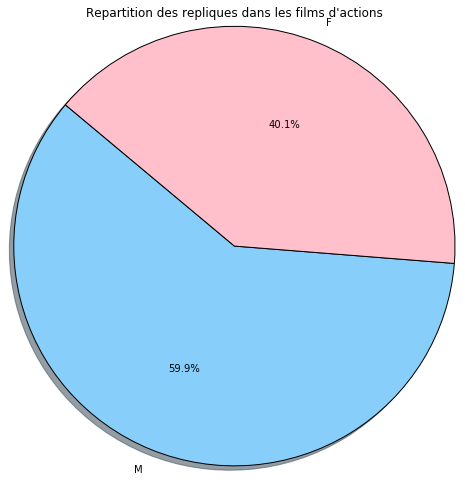

In [295]:
m=sum(male_nb_speech)
f=sum(female_nb_speech)

 
# Data to plot
labels = ["M","F"]
sizes = [m, f]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Repartition des repliques dans les films d'actions") 
plt.axis('equal')
plt.show()

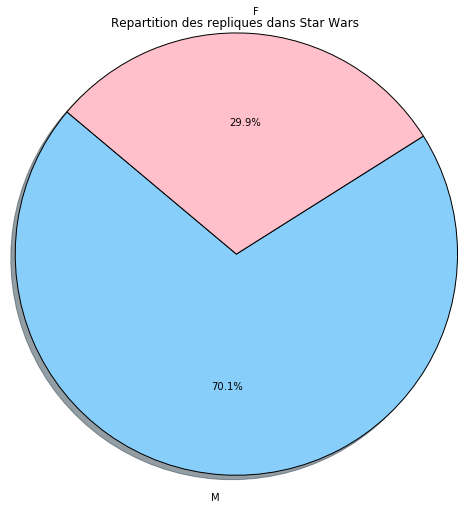

In [292]:
male_nb_speech=len(output[1][output[1]['gender']=='M'])
female_nb_speech=len(output[1][output[1]['gender']=='F'])

 
# Data to plot
labels = ["M","F"]
sizes = [male_nb_speech, female_nb_speech]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Repartition des repliques dans Star Wars') 
plt.axis('equal')
plt.show()

In [296]:
romance=['http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html','http://www.imsdb.com/scripts/Amour.html',
        'http://www.imsdb.com/scripts/Barry-Lyndon.html','http://www.imsdb.com/scripts/Color-of-Night.html',
        'http://www.imsdb.com/scripts/Date-Night.html','http://www.imsdb.com/scripts/Her.html',
        'http://www.imsdb.com/scripts/Kate-&-Leopold.html','http://www.imsdb.com/scripts/500-Days-of-Summer.html',
        'http://www.imsdb.com/scripts/Wild-At-Heart.html']
output=[]

for url in romance:
    path='../data/script/'
    name=url.replace(':','').replace('/','')
    test=parse(url,path,name)
    output.append(test)

('Detected encoding is ', u'iso-8859-1')
Found a <pre> inside the <pre>
Getting script @ http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html.
      Done parsing script at http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html in 2.17573213577
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Amour.html.
      Done parsing script at http://www.imsdb.com/scripts/Amour.html in 1.06749892235
-----------------
('Detected encoding is ', u'iso-8859-1')
Found a <pre> inside the <pre>
Getting script @ http://www.imsdb.com/scripts/Barry-Lyndon.html.
      Done parsing script at http://www.imsdb.com/scripts/Barry-Lyndon.html in 1.11393809319
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Color-of-Night.html.
      Done parsing script at http://www.imsdb.com/scripts/Color-of-Night.html in 1.31193590164
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting scr

In [297]:
#construct character info and add it to dataframe
output_=[]
male_nb_speech=[]
female_nb_speech=[]
for df in output:
    try:
        test=df['character'].apply(lambda x :clean_character(x))
        df['character_clean']=continued_speech(test)
        char,gender=char_analysis(df)
        output_.append(char)
        #create gender column in dataframe:
        df['gender']=[gender.get(item,item)  for item in list(df['character_clean'])]
        male_nb_speech.append(len(df[df['gender']=='M']))
        female_nb_speech.append(len(df[df['gender']=='F']))
    except Exception as e:
        print('Caught exception : %s' %e)
        

Caught exception : unbalanced parenthesis
Caught exception : unbalanced parenthesis


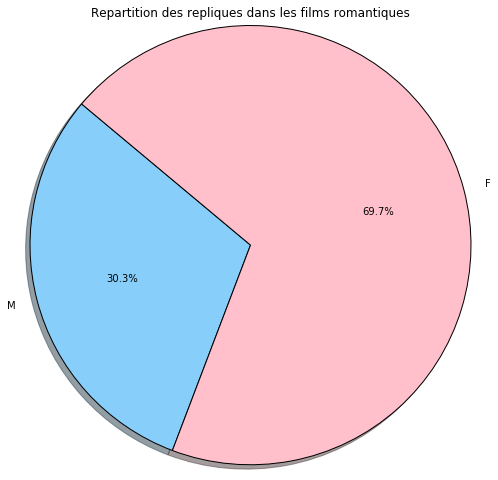

In [299]:
m=sum(male_nb_speech)
f=sum(female_nb_speech)

 
# Data to plot
labels = ["M","F"]
sizes = [m, f]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Repartition des repliques dans les films romantiques") 
plt.axis('equal')
plt.show()

In [303]:
m=0
f=0
for key,value in gender.items():
    if value=="F":
        f=f+1
m=len(gender)-f

In [305]:
m

17